# Import Libraries

In [234]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from skimage.feature import greycomatrix, greycoprops
from skimage import color
from skimage import io
from skimage import exposure
import natsort as ns
import multiprocessing
from tqdm import tqdm_notebook
from PIL import Image
from skimage.util import *

# Load Images

In [235]:
path = os.getcwd()

im_dir = r''+ path + '/Zurich_dataset/images_tif/'
gt_dir = r''+ path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

def im_load(path, max_size = 600): # for now, only return highest [max_size] pixels, multiple of patch_size
    """load a TIF image"""
    image = np.asarray(io.imread(path)).astype(float)
    #print(image.shape)
    return np.asarray(image[:max_size,:max_size,:])


def get_im_patches(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

images: 20 
ground truth images: 20 


In [236]:
imgs = np.asarray([im_load(im_dir + im_name, max_size = 512) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name, max_size = 512) for gt_name in gt_names])
print(imgs.shape)

(20, 512, 512, 4)


In [237]:
# Loaded a set of images
def imgs_stretch_eq(imgs):
    imgs_stretch, imgs_eq = [], []
    for im in imgs:
        # Contrast stretching
        p2, p98 = np.percentile(im, (2, 98))
        img_stretch = im.copy()
        img_eq = im.copy()
        for band in range(im.shape[-1]):
            img_stretch[:,:,band] = exposure.rescale_intensity(im[:,:,band], in_range=(p2, p98))
            img_eq[:,:,band] = exposure.equalize_hist(img_stretch[:,:,band])
        
        # append images
        imgs_stretch.append(img_stretch)
        
        imgs_eq.append(img_eq)
        
    # convert to np arrays
    imgs_stretch = np.asarray(imgs_stretch)
    imgs_eq = np.asarray(imgs_eq)
    return imgs_stretch, imgs_eq 

imgs_stretch, imgs_eq = imgs_stretch_eq(imgs)

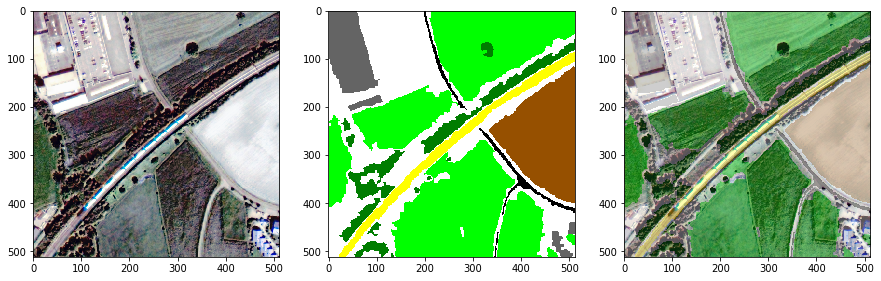

In [238]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 0
overlay = imgs_eq[i][:,:,:3]*.7+gt[i]/255*.3

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs_eq[i][:,:,:3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
plt.show()

In [239]:
imgs = imgs_eq # continue using stretched image

In [240]:
print(np.shape(imgs))
print(np.shape(gt))

(20, 512, 512, 4)
(20, 512, 512, 3)


## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [241]:
# get label corresponding to each color
from collections import OrderedDict

legend = OrderedDict((('Background',[0, 0, 0]),
          ('Roads',[255, 255, 255]),
          ('Buildings',[100, 100, 100]),
          ('Trees',[0, 125, 0]),
          ('Grass',[0, 255, 0]),
          ('Bare Soil',[150, 80, 0]),
          ('Water',[0, 0, 150]),
          ('Railways',[255, 255, 0]),
          ('Swimming Pools',[150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(np.sum(color))

In [242]:
def gt_color_to_label(gt, maj = False):
    # sum of distinct color values
    gt_new = np.sum(gt,axis=3).astype(int) 

    # replace colors by new values
    for i in range(len(colors)):
        gt_new[gt_new == colors[i]] = i #np.argsort(colors)[i]
    
    if maj:
        # return only majority label for each patch
        gt_maj_label = []
        for i in range(len(gt)):
            counts = np.bincount(gt_new[i].flatten())
            gt_maj_label.append(np.argmax(counts))

        gt_new = np.asarray([gt_maj_label]).T
        
    return gt_new

In [243]:
def rgb2gray(rgb):
    return np.asarray([np.dot(im[...,:3], [0.299, 0.587, 0.114]) for im in rgb])

gt_gray = rgb2gray(gt)
gt_gray.shape

(20, 512, 512)

In [244]:
gt_maj_label = gt_color_to_label(gt)
print("Unique Labels in GT: ", np.unique(gt_maj_label))
print(np.shape(gt_maj_label))
gt = gt_maj_label

Unique Labels in GT:  [0 1 2 3 4 5 6 7 8]
(20, 512, 512)


## Get patches

In [245]:
def get_padded_patches(images, patch_size = 16, window_size = 64):
    """
    get padded (mirror) patches for all images
    """
    patches = []
    for im in tqdm_notebook(images):
        patches_im = np.zeros([int(im.shape[0]/patch_size),int(im.shape[0]/patch_size), window_size, window_size, im.shape[2]])    
        for i in range(np.shape(im)[2]):
            padded = np.lib.pad(im[:,:,i], int(np.floor((window_size-patch_size)/2)), 'reflect')    
            patches_im[:,:,:,:,i] = view_as_windows(padded, window_size, step=patch_size)
            
        n_patches = int((im.shape[0]/patch_size)**2) # 25*25 = 625 per image
        patches_im = np.reshape(patches_im, (n_patches, window_size, window_size, im.shape[2]))

        # TODO reshape patches (first dim)
        patches.append(patches_im)
    patches = np.array(patches)
    patches =  np.asarray([patches[i][j] for i in range(len(patches)) for j in range(len(patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return patches

def get_gt_patches(images_gt, patch_size = 16):
    """
    get ground truth patches for all images
    """
    gt_patches = []
    for im in tqdm_notebook(images_gt):
        patches_im_gt = view_as_blocks(im, block_shape=(patch_size, patch_size))         
        n_patches = int((im.shape[0]/patch_size)**2) # 25*25 = 625 per image
        patches_im_gt = np.reshape(patches_im_gt, (n_patches, patch_size, patch_size))

        gt_patches.append(patches_im_gt)
    gt_patches = np.array(gt_patches)
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return np.asarray(gt_patches)

In [246]:
print(imgs.shape)
print(gt.shape)

(20, 512, 512, 4)
(20, 512, 512)


In [247]:
im_patches = get_padded_patches(imgs, patch_size = 128, window_size = 128)
gt_patches = get_gt_patches(gt, patch_size = 128)
print(im_patches.shape)
print(gt_patches.shape)



(320, 128, 128, 4)
(320, 128, 128)


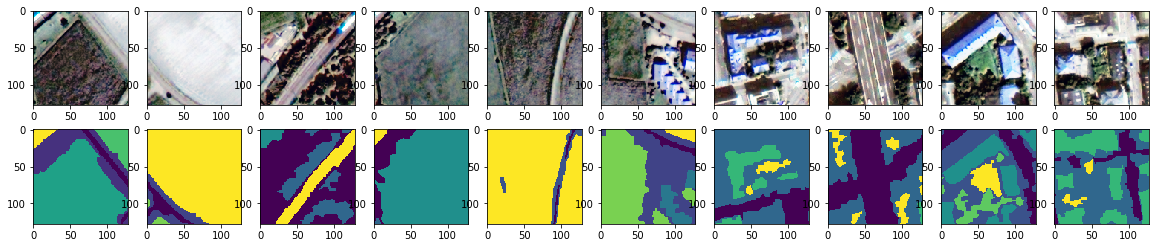

In [268]:
imgs_row = 10
fig, axes = plt.subplots(2,imgs_row)
fig.set_size_inches(imgs_row*2,4)
offset = 10
for i in range(offset, offset + imgs_row):
    axes[0][i-offset].imshow(im_patches[i][:,:,:3])
    axes[1][i-offset].imshow(gt_patches[i]/9)

[0 1 2 3 4 5 6 7 8] [ 765495 2098531 1191470  460171  390497   45045  183389  103897    4385]


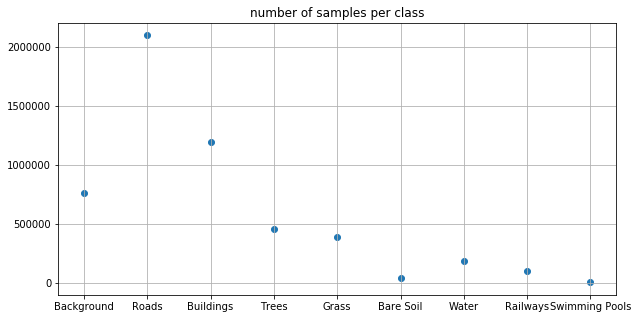

In [269]:
# print some statistics for the new labels
unique, counts = np.unique(gt,return_counts=True)
print(unique, counts)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)
ax.scatter(unique,counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

# Keras test

In [270]:
np.random.seed(42)

from __future__ import print_function

import h5py
import sklearn # accuracy metrics
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import tensorflow as tf
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers 

import keras
import keras.backend as K
from keras import metrics
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.utils import to_categorical
import keras.losses
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import *

In [271]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(gt.flatten()), gt.flatten())
class_weights[0] = 1 # give less weight to background label class
class_weights[8] = 1 # give less weight to swimming pool class
print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f"%(names[i],w))

x_train, x_val, y_train, y_val  = train_test_split(im_patches, gt_patches, test_size=.2, random_state = 42)

Class weights:
     Background: 1.000
          Roads: 0.278
      Buildings: 0.489
          Trees: 1.266
          Grass: 1.492
      Bare Soil: 12.932
          Water: 3.177
       Railways: 5.607
 Swimming Pools: 1.000


In [272]:
n_classes = 9

# if we want to use all data for training 
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)

# make y data categorical
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)

In [273]:
# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

(256, 128, 128, 4)
(256, 128, 128, 9)
(64, 128, 128, 4)
(64, 128, 128, 9)


## UNET

In [277]:
def get_unet():
    
    # model parameters
    n_classes = 9
    input_shape=x_train.shape[1:]
    reg = 1e-6
    inputs = Input(input_shape)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [278]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

# callbacks (evaluated every epoch)
# keep track of the accuracy over epochs
callback_history = AccuracyHistory()

# stop early if after several epochs the accuracy doesn't improive
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto', 
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
filepath="weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')

In [ ]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

batch_size = 2000
epochs = 2000

def model_train(model, data_augmentation = True):
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              class_weight = class_weights,
              validation_data = (x_val, y_val),
              callbacks=[callback_history, 
                         callback_earlystop, 
                         callback_lr, 
                         callback_checkpoint])
    else:
        print('Using real-time data augmentation.')

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                            epochs=epochs,
                            verbose=1,
                            class_weight = class_weights,
                            validation_data=(x_val, y_val),
                            callbacks=[callback_history, 
                                       callback_earlystop,
                                       callback_lr,
                                       callback_checkpoint],
                            workers=multiprocessing.cpu_count()-1,
                            use_multiprocessing=True)
        

# train the model
model = get_unet()
#model.load_weights('weights-improvement.hdf5')
model_train(model, data_augmentation = False)

Not using data augmentation.
Train on 256 samples, validate on 64 samples
Epoch 1/2000
256/256 [==============================] - 10s 41ms/step - loss: 2.1983 - categorical_accuracy: 0.0363 - val_loss: 2.1833 - val_categorical_accuracy: 0.1853
Epoch 2/2000
256/256 [==============================] - 5s 19ms/step - loss: 2.1808 - categorical_accuracy: 0.2102 - val_loss: 2.1605 - val_categorical_accuracy: 0.2051
Epoch 3/2000
256/256 [==============================] - 4s 16ms/step - loss: 2.1552 - categorical_accuracy: 0.2454 - val_loss: 2.1138 - val_categorical_accuracy: 0.1974
Epoch 4/2000
256/256 [==============================] - 4s 16ms/step - loss: 2.1020 - categorical_accuracy: 0.2389 - val_loss: 1.9933 - val_categorical_accuracy: 0.1966
Epoch 5/2000
256/256 [==============================] - 4s 16ms/step - loss: 1.9518 - categorical_accuracy: 0.2381 - val_loss: 2.3495 - val_categorical_accuracy: 0.1937
Epoch 6/2000
256/256 [==============================] - 5s 19ms/step - loss: 2.1

Epoch 49/2000
256/256 [==============================] - 4s 16ms/step - loss: 1.5569 - categorical_accuracy: 0.3714 - val_loss: 1.6002 - val_categorical_accuracy: 0.3432
Epoch 50/2000
256/256 [==============================] - 4s 16ms/step - loss: 1.5433 - categorical_accuracy: 0.3861 - val_loss: 1.5997 - val_categorical_accuracy: 0.3635
Epoch 51/2000
256/256 [==============================] - 5s 19ms/step - loss: 1.5321 - categorical_accuracy: 0.4052 - val_loss: 1.5907 - val_categorical_accuracy: 0.3751
Epoch 52/2000
256/256 [==============================] - 4s 16ms/step - loss: 1.5178 - categorical_accuracy: 0.4147 - val_loss: 1.5513 - val_categorical_accuracy: 0.3727
Epoch 53/2000
256/256 [==============================] - 4s 16ms/step - loss: 1.4876 - categorical_accuracy: 0.4131 - val_loss: 1.5275 - val_categorical_accuracy: 0.3678
Epoch 54/2000
256/256 [==============================] - 5s 19ms/step - loss: 1.4771 - categorical_accuracy: 0.4090 - val_loss: 1.5306 - val_categoric

# Prediction

In [ ]:
# save the model
model.save('model_unet_64_aug.h5')  # save model, weights
#del model  # deletes the existing modelon set

In [ ]:
score = model.evaluate(x_val, y_val, batch_size = 1, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
x_val.shape

In [ ]:
y_pred = model.predict(x_val, batch_size = 3, verbose = 1)

In [ ]:
y_pred = np.argmax(y_pred,axis=3)

In [ ]:
y_val_fig = np.argmax(y_val,axis=3)

In [ ]:
im_idx = 2
fig, axes = plt.subplots(1,3)
fig.set_size_inches(10,5)
axes[0].imshow(x_val[im_idx][:,:,:3])
axes[1].imshow(y_val_fig[im_idx])
axes[2].imshow(y_pred[im_idx])

In [103]:
# Display prediction as an image
img_idx = 2 # the test image id
patch_size = 16 # patch size
images_set = imgs_test # the image set we want to classify
images_patches_set = im_test_patches # the patches

w = np.asarray(images_set).shape[1]
h = np.asarray(images_set).shape[2]

# get labels
n_patches_im = int(w**2/patch_size**2) # number of patches for one image
patches_idx_begin = 0 + n_patches_im*img_idx # start index of patches belonging to an image
patches_idx_end = n_patches_im + n_patches_im*img_idx # end index

y_pred = model.predict(images_patches_set[patches_idx_begin:patches_idx_end])
y_pred = (y_pred[:,0] < y_proed[:,1])*1
labels_pred = label_to_img(w, h, patch_size, patch_size, y_pred)
#Zi_real = gt_patches_maj[patches_idx_begin:patches_idx_end]
#labels_real = label_to_img(w, h, patch_size, patch_size, Zi_real)

# plot figure
fig, axes = plt.subplots(1,2)
fig.set_size_inches((15, 4)) # create a figure with the default size 
axes[0].imshow(images_set[img_idx], cmap='Greys_r')
axes[1].imshow(labels_pred, cmap='Greys_r')
#axes[2].imshow(labels_real, cmap='Greys_r')

NameError: name 'imgs_test' is not defined

In [ ]:
# Validation accuracy
y_pred_val = model.predict(x_val)
# convert 2 classes to one
y_pred_val = np.argmax(y_pred_val, axis = 3)
y_val = np.argmax(y_val, axis = 3)
print("Validation accuracy: ")
print(sklearn.metrics.accuracy_score(y_pred_val.flatten(),y_val.flatten()))
#print(sklearn.metrics.f1_score(y_pred_val.flatten().astype(int),y_val.flatten().astype(int)))#print(sklearn.metrics.jaccard_similarity_score(y_pred_val.flatten().astype(int),y_val.flatten().astype(int)))